<>:11: SyntaxWarning: invalid escape sequence '\I'
<>:11: SyntaxWarning: invalid escape sequence '\I'
C:\Users\admin\AppData\Local\Temp\ipykernel_27536\1048340956.py:11: SyntaxWarning: invalid escape sequence '\I'
  image_path = 'C:\IMAGE ENHANCEMENT PROJECT\Gemini_Generated_Image_32rjf232rjf232rj.png'  # <-- CHANGE THIS to your image file


Loading Models...
Enhancing Image...
Running Detection...


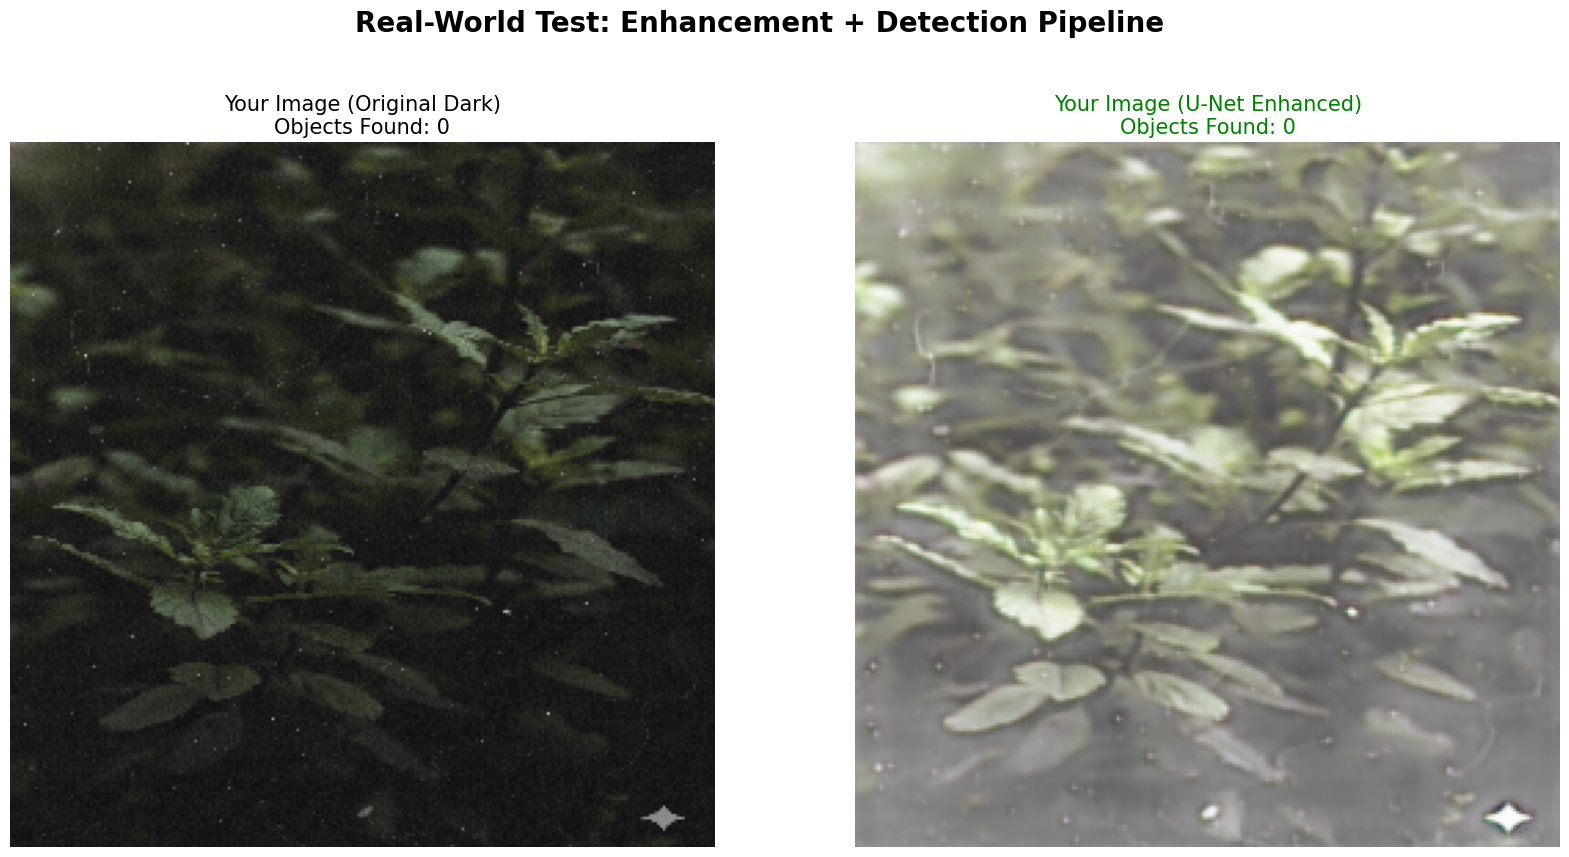

Done!


In [ ]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from ultralytics import YOLO
%run my_model.ipynb # Ensure your UNet class is importable

# --- CONFIGURATION ---
image_path = 'C:\IMAGE ENHANCEMENT PROJECT\trees.jpg'  # <-- CHANGE THIS to your image file
model_path = 'unet_enhancer_20e.pth'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 1. Load Models
print("Loading Models...")
unet = UNet().to(device)
unet.load_state_dict(torch.load(model_path, map_location=device))
unet.eval()

yolo = YOLO('yolov8n.pt')

# 2. Preprocess the Custom Image
# The model expects exactly 256x256 pixels
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

original_pil = Image.open(image_path).convert("RGB")
input_tensor = transform(original_pil).unsqueeze(0).to(device)

# 3. Step 1: Enhance with U-Net
print("Enhancing Image...")
with torch.no_grad():
    enhanced_tensor = unet(input_tensor)

# 4. Step 2: Convert to OpenCV format for YOLO
def tensor_to_cv2(tensor):
    img = tensor.squeeze(0).cpu().permute(1, 2, 0).numpy()
    img = (img * 255).astype(np.uint8)
    return cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

# We also resize the original for a fair comparison plot
low_res_original = cv2.resize(cv2.cvtColor(np.array(original_pil), cv2.COLOR_RGB2BGR), (256, 256))
img_enhanced_cv2 = tensor_to_cv2(enhanced_tensor)

# 5. Step 3: Run YOLO Detection
print("Running Detection...")
results_dark = yolo(low_res_original, verbose=False)
results_enh = yolo(img_enhanced_cv2, verbose=False)

# 6. Visualization
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Plot Dark Image Detection
res_dark_plot = cv2.cvtColor(results_dark[0].plot(), cv2.COLOR_BGR2RGB)
axes[0].imshow(res_dark_plot)
axes[0].set_title(f"Your Image (Original Dark)\nObjects Found: {len(results_dark[0].boxes)}", fontsize=15)
axes[0].axis('off')

# Plot Enhanced Image Detection
res_enh_plot = cv2.cvtColor(results_enh[0].plot(), cv2.COLOR_BGR2RGB)
axes[1].imshow(res_enh_plot)
axes[1].set_title(f"Your Image (U-Net Enhanced)\nObjects Found: {len(results_enh[0].boxes)}", fontsize=15, color='green')
axes[1].axis('off')

plt.suptitle("Real-World Test: Enhancement + Detection Pipeline", fontsize=20, fontweight='bold')
plt.show()

print("Done!")


In [6]:
from my_dataset import LOLDataset
from torchvision import transforms

# 1. Re-initialize the dataset
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

test_dataset = LOLDataset(
    root_dir='data/lol_dataset/eval15/', 
    transform=transform
)

# 2. Define the plotting helper
def to_plt(tensor):
    return tensor.squeeze(0).cpu().permute(1, 2, 0).numpy()

print("Dataset and Helper function are ready.")

Dataset and Helper function are ready.


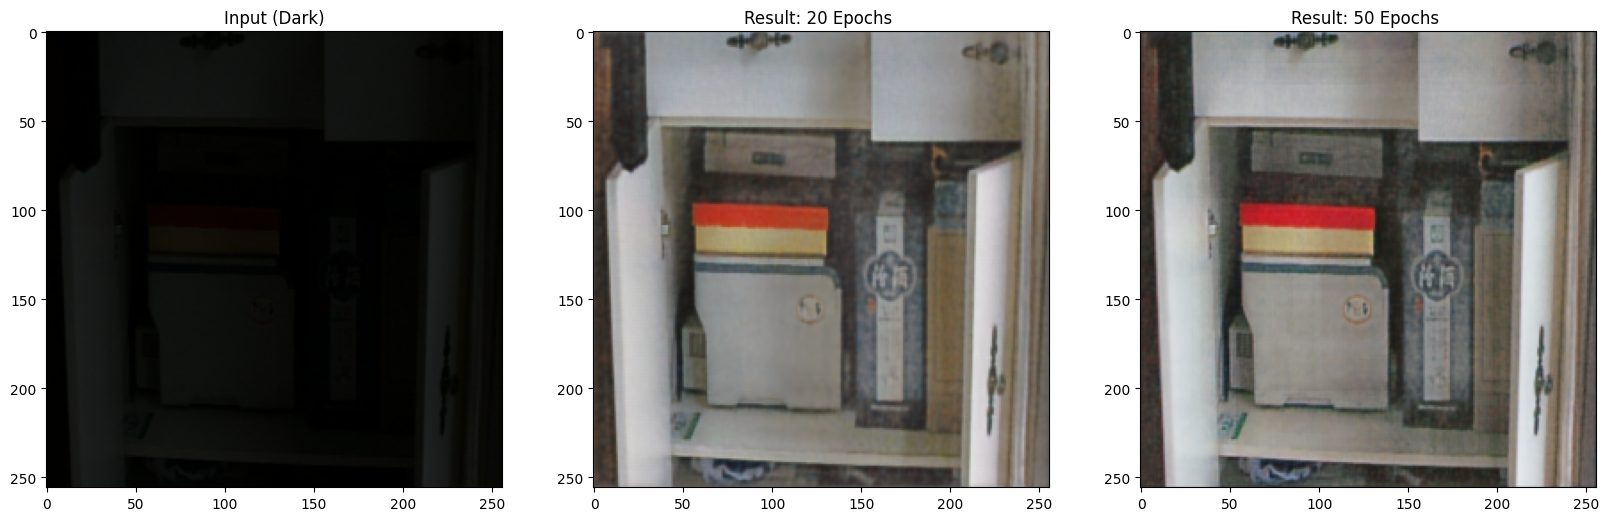

In [14]:
import torch
import matplotlib.pyplot as plt

# Load 20-epoch model
model_20 = UNet().to(device)
model_20.load_state_dict(torch.load('unet_enhancer_20e.pth', map_location=device))

# Load 50-epoch model
model_50 = UNet().to(device)
model_50.load_state_dict(torch.load('unet_enhancer.pth', map_location=device)) # Or your 50e filename

# Get a sample
low, high = test_dataset[8]
with torch.no_grad():
    enh_20 = model_20(low.unsqueeze(0).to(device))
    enh_50 = model_50(low.unsqueeze(0).to(device))

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(20, 7))
axes[0].imshow(to_plt(low.unsqueeze(0))); axes[0].set_title("Input (Dark)")
axes[1].imshow(to_plt(enh_20)); axes[1].set_title("Result: 20 Epochs ")
axes[2].imshow(to_plt(enh_50)); axes[2].set_title("Result: 50 Epochs ")
plt.show()

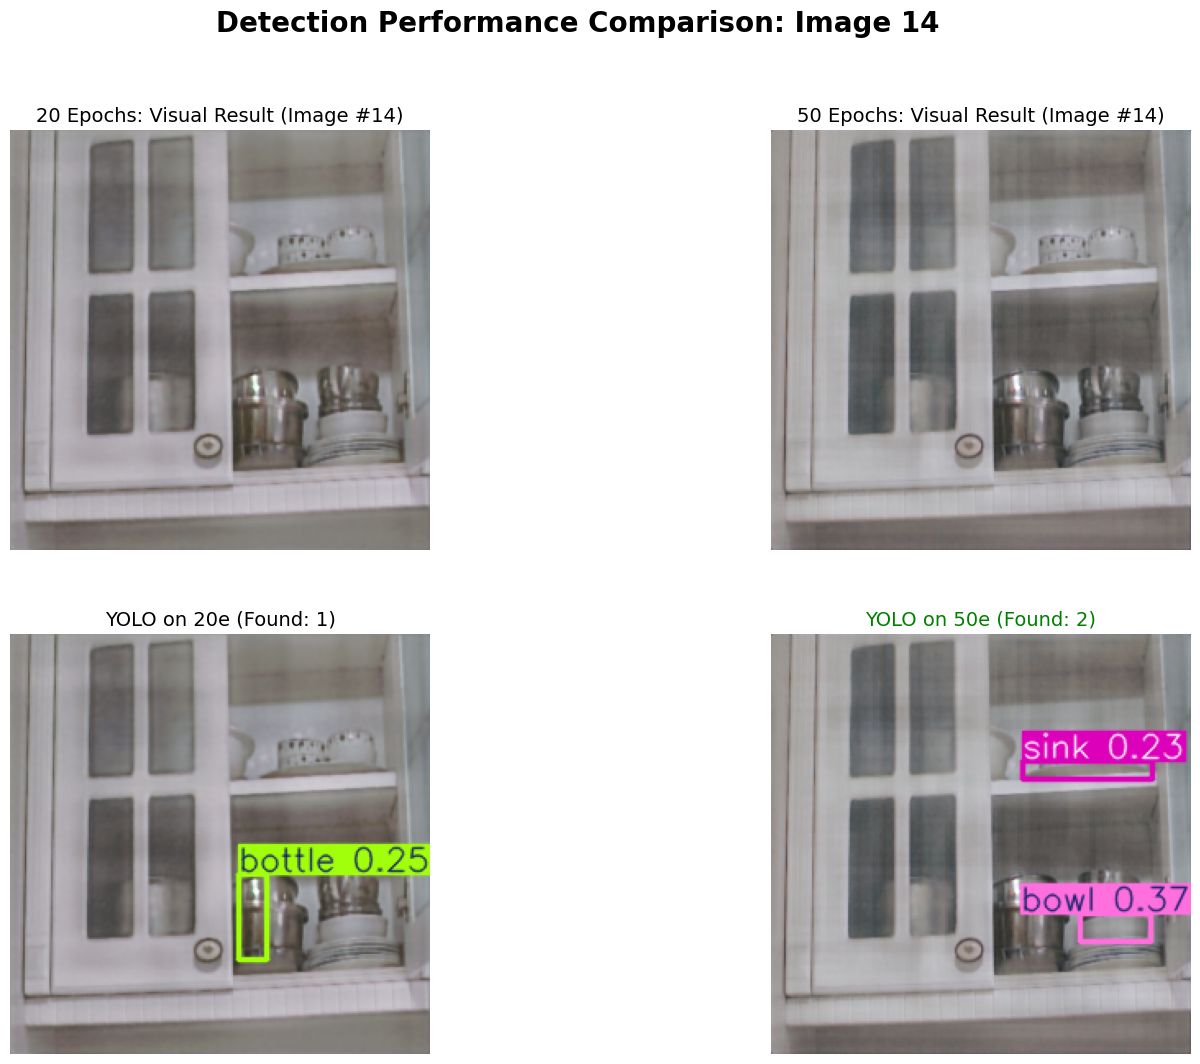

In [23]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

# --- 1. SETUP & UTILS (To prevent NameErrors) ---
def to_plt(tensor):
    """Converts torch tensor to a format Matplotlib can show."""
    return tensor.squeeze(0).cpu().permute(1, 2, 0).numpy()

def get_yolo_result(tensor, yolo_model, conf_thresh=0.20):
    """Helper to run YOLO and return the plotted image + count."""
    # Convert tensor to CV2 BGR format
    img_np = (tensor.squeeze(0).cpu().permute(1, 2, 0).numpy() * 255).astype('uint8')
    img_bgr = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)
    
    # Run Inference
    results = yolo_model(img_bgr, conf=conf_thresh, verbose=False)[0]
    
    # Plot results back to RGB for Matplotlib
    res_plot = cv2.cvtColor(results.plot(), cv2.COLOR_BGR2RGB)
    return res_plot, len(results.boxes)

# --- 2. SELECT YOUR IMAGE HERE ---
# Choose any index from 0 to 14 (for your 15 test images)
image_index = 14  # <--- CHANGE THIS NUMBER TO SEE DIFFERENT IMAGES

# --- 3. RUN COMPARISON ---
# Grab the image
low, high = test_dataset[image_index]

# Inference with both models
model_20.eval()
model_50.eval()
with torch.no_grad():
    enh_20 = model_20(low.unsqueeze(0).to(device))
    enh_50 = model_50(low.unsqueeze(0).to(device))

# Get YOLO detections
plot_20, count_20 = get_yolo_result(enh_20, yolo_model)
plot_50, count_50 = get_yolo_result(enh_50, yolo_model)

# --- 4. DISPLAY DASHBOARD ---
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Row 1: Visual Comparison
axes[0, 0].imshow(to_plt(enh_20))
axes[0, 0].set_title(f"20 Epochs: Visual Result (Image #{image_index})", fontsize=14)
axes[0, 0].axis('off')

axes[0, 1].imshow(to_plt(enh_50))
axes[0, 1].set_title(f"50 Epochs: Visual Result (Image #{image_index})", fontsize=14)
axes[0, 1].axis('off')

# Row 2: YOLO Detection Comparison
axes[1, 0].imshow(plot_20)
axes[1, 0].set_title(f"YOLO on 20e (Found: {count_20})", fontsize=14)
axes[1, 0].axis('off')

axes[1, 1].imshow(plot_50)
axes[1, 1].set_title(f"YOLO on 50e (Found: {count_50})", fontsize=14, color='green')
axes[1, 1].axis('off')

plt.suptitle(f"Detection Performance Comparison: Image {image_index}", fontsize=20, fontweight='bold')
plt.show()